# LaLiga Data Analysis

First of all we import the necessary libraries and define some functions, the first of them to create the connection with the database.

In [23]:
import pandas as pd
import numpy as np
import sqlite3
import datetime as dt
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
conn = sqlite3.connect('../laliga.sqlite')

# Function to execute a query and return the result as a pandas DataFrame
def run_query(query, conn):
    return pd.read_sql_query(query, conn)

# Function to calculate goals for home and away teams
def split_score(score):
    home_goals, away_goals = map(int, score.split(':'))
    return home_goals, away_goals

# Function to determine the outcome of a match based on the score
def determine_result(score):
    # Split the score into home and away goals
    home_goals, away_goals = split_score(score)
    # Determine the match result
    if home_goals > away_goals:
        return 'Home Wins'
    elif home_goals < away_goals:
        return 'Away Wins'
    else:
        return 'Tie'
    
# Function to parse dates and correct the year
def parse_date_mdy_format(date_str):
    parts = date_str.split('/')
    month, day, year_component = parts
    month = int(month)
    day = int(day)
    year_component = int(year_component)
    if year_component < 28:
        year_component += 2000
    else:
        year_component += 1900
    return datetime(year=year_component, month=month, day=day).strftime('%Y-%m-%d')

# Function to convert time to 24-hour format
def convert_time_to_24h(time_str):
    if pd.isnull(time_str) or time_str == '':
        return None
    try:
        return dt.datetime.strptime(time_str, '%I:%M %p').time()
    except ValueError:
        return None

## 1.
Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or there’s a tie) of all matches in the data. Write in the plot the percentage of each category.

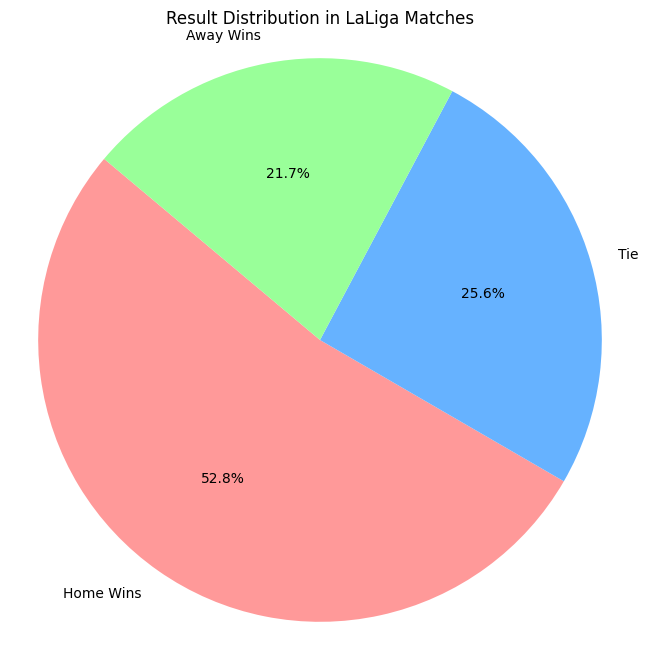

In [25]:
# Select all the scores from the Matches table to analyze results
scores_query = "SELECT score FROM Matches;"

# Run the query and store the results in a DataFrame
scores = run_query(scores_query, conn)

# Remove any rows with missing scores
scores.dropna(inplace=True)

# Apply the result determination function to each score
results = scores['score'].apply(determine_result)

# Calculate the normalized distribution of match results
results_distribution = results.value_counts(normalize=True)

# Set the color scheme for the pie chart
colors = ['#FF9999', '#66B2FF', '#99FF99']
# Create a pie chart to visualize the distribution of match results
plt.figure(figsize=(8, 8))
plt.pie(results_distribution, labels=results_distribution.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Result Distribution in LaLiga Matches')
plt.axis('equal')  # Ensure the pie chart is a circle
plt.show()

## 2.
What are the top ten scoring teams of all time? What are the ten teams that concede the most? Make two bar plot charts showing each of them. Consider only matches played in 1st division.

What have been the biggest wins? Of course, when we say biggest we mean those with the highest goal difference. Show the top ten of them in a table.

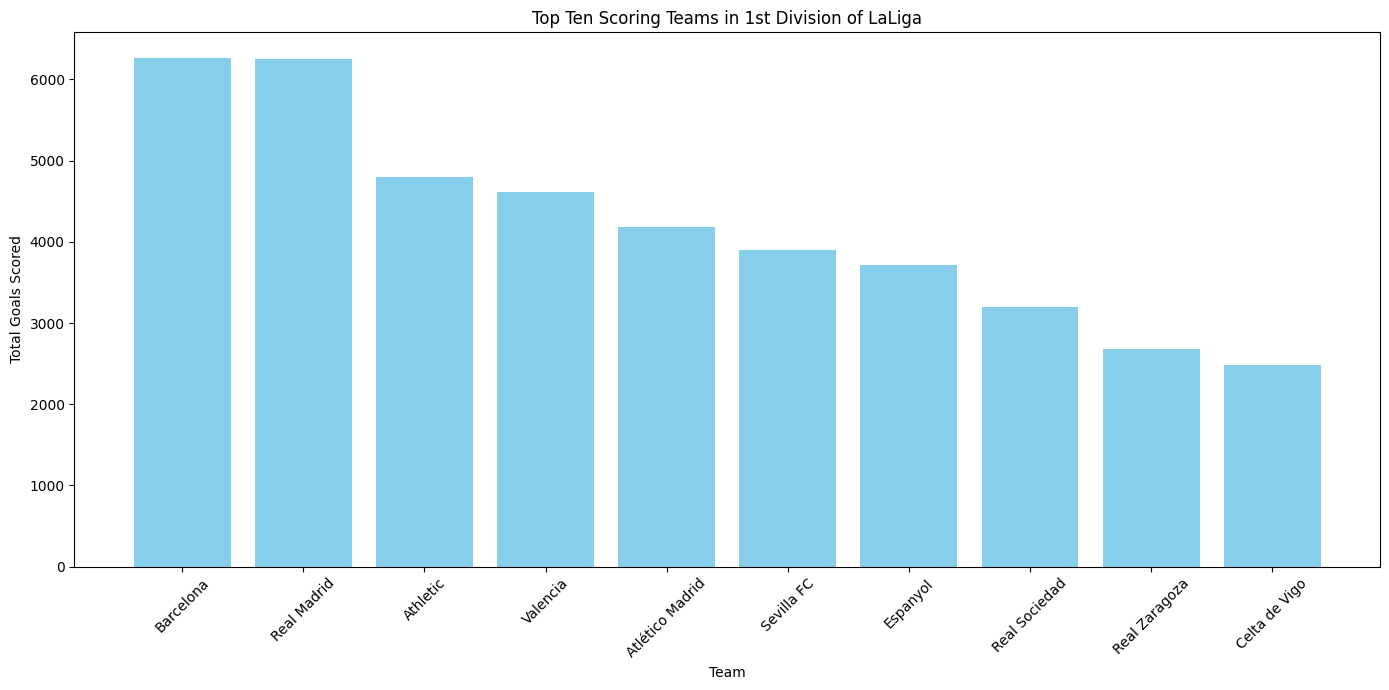

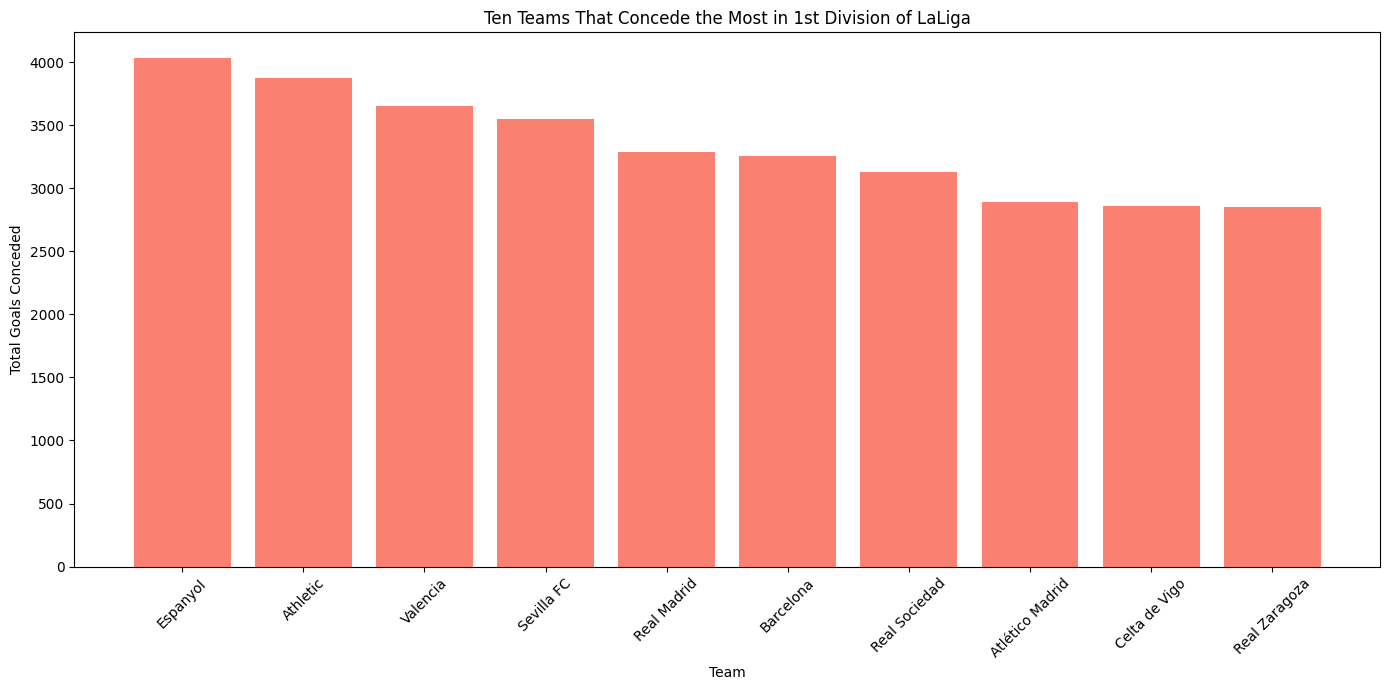

In [26]:
# Function to retrieve and process the goals data
def get_goals_data():
    # Query to get the home and away goals for 1st division matches
    goals_query = """
    SELECT 
        home_team, 
        away_team, 
        CASE 
            WHEN score IS NOT NULL THEN CAST(SUBSTR(score, 1, INSTR(score, ':') - 1) AS INTEGER)
            ELSE 0 END AS home_goals,
        CASE 
            WHEN score IS NOT NULL THEN CAST(SUBSTR(score, INSTR(score, ':') + 1) AS INTEGER)
            ELSE 0 END AS away_goals
    FROM Matches
    WHERE division = 1;
    """
    
    # Execute the query and return the result
    goals_data = run_query(goals_query, conn)
    
    # Calculate the total goals scored and conceded by each team
    home_goals = goals_data.groupby('home_team')['home_goals'].sum().reset_index()
    away_goals = goals_data.groupby('away_team')['away_goals'].sum().reset_index()
    home_conceded = goals_data.groupby('home_team')['away_goals'].sum().reset_index()
    away_conceded = goals_data.groupby('away_team')['home_goals'].sum().reset_index()
    
    # Merge the home and away goals to get the total goals for each team
    total_goals_scored = pd.merge(home_goals, away_goals, left_on='home_team', right_on='away_team')
    total_goals_scored['total_goals'] = total_goals_scored['home_goals'] + total_goals_scored['away_goals']
    total_goals_scored = total_goals_scored[['home_team', 'total_goals']].rename(columns={'home_team': 'team'})
    
    # Merge the home and away conceded goals to get the total conceded goals for each team
    total_goals_conceded = pd.merge(home_conceded, away_conceded, left_on='home_team', right_on='away_team')
    total_goals_conceded['total_conceded'] = total_goals_conceded['away_goals'] + total_goals_conceded['home_goals']
    total_goals_conceded = total_goals_conceded[['home_team', 'total_conceded']].rename(columns={'home_team': 'team'})
    
    return total_goals_scored, total_goals_conceded

# Get the goals data
total_goals_scored, total_goals_conceded = get_goals_data()

# Sort and get the top ten scoring teams
top_scoring_teams = total_goals_scored.sort_values('total_goals', ascending=False).head(10)

# Sort and get the ten teams that concede the most
most_conceding_teams = total_goals_conceded.sort_values('total_conceded', ascending=False).head(10)

# Plot the top ten scoring teams
plt.figure(figsize=(14, 7))
plt.bar(top_scoring_teams['team'], top_scoring_teams['total_goals'], color='skyblue')
plt.title('Top Ten Scoring Teams in 1st Division of LaLiga')
plt.xlabel('Team')
plt.ylabel('Total Goals Scored')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the ten teams that concede the most
plt.figure(figsize=(14, 7))
plt.bar(most_conceding_teams['team'], most_conceding_teams['total_conceded'], color='salmon')
plt.title('Ten Teams That Concede the Most in 1st Division of LaLiga')
plt.xlabel('Team')
plt.ylabel('Total Goals Conceded')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Function to retrieve and process the biggest wins data
def get_biggest_wins():
    # Query to get the matches with score for 1st division matches
    wins_query = """
    SELECT 
        season, 
        date, 
        home_team, 
        away_team, 
        score,
        CAST(SUBSTR(score, 1, INSTR(score, ':') - 1) AS INTEGER) AS home_goals,
        CAST(SUBSTR(score, INSTR(score, ':') + 1) AS INTEGER) AS away_goals
    FROM Matches
    WHERE 
        division = 1 AND 
        score IS NOT NULL;
    """
    
    # Execute the query and return the result
    wins_data = run_query(wins_query, conn)
    
    # Calculate goal difference for each match
    wins_data['goal_difference'] = abs(wins_data['home_goals'] - wins_data['away_goals'])
    
    # Sort by goal difference to find the biggest wins
    biggest_wins = wins_data.sort_values('goal_difference', ascending=False).head(10)
    
    # Select relevant columns for display
    biggest_wins = biggest_wins[['season', 'date', 'home_team', 'away_team', 'score', 'goal_difference']]
    
    return biggest_wins

# Get the biggest wins data
biggest_wins = get_biggest_wins()
biggest_wins

,season,date,home_team,away_team,score,goal_difference
225,1930-1931,2/8/31,Athletic,Barcelona,12:1,11
936,1940-1941,9/29/40,Sevilla FC,Barcelona,11:1,10
2787,1950-1951,11/19/50,Athletic,Lérida,10:0,10
1168,1941-1942,1/11/42,Athletic,Celta de Vigo,10:0,10
1071,1941-1942,9/28/41,Sevilla FC,Real Oviedo,10:0,10
3629,1953-1954,3/28/54,Barcelona,Real Oviedo,9:0,9
10024,1978-1979,1/14/79,Barcelona,Rayo Vallecano,9:0,9
408,1932-1933,1/29/33,Racing,Alavés,9:0,9
5027,1959-1960,2/7/60,Real Madrid,Elche CF,11:2,9
3911,1955-1956,9/11/55,Atlético Madrid,Hércules CF,9:0,9


## 3.
There has been a lot of discussion about how LaLiga’s television rights have changed game schedules in the last years. Make a bar plot chart showing the number of matches played each weekday, and make also a histogram of match time. Compare this two graphics between seasons 2000-2001 and 2020-2021.

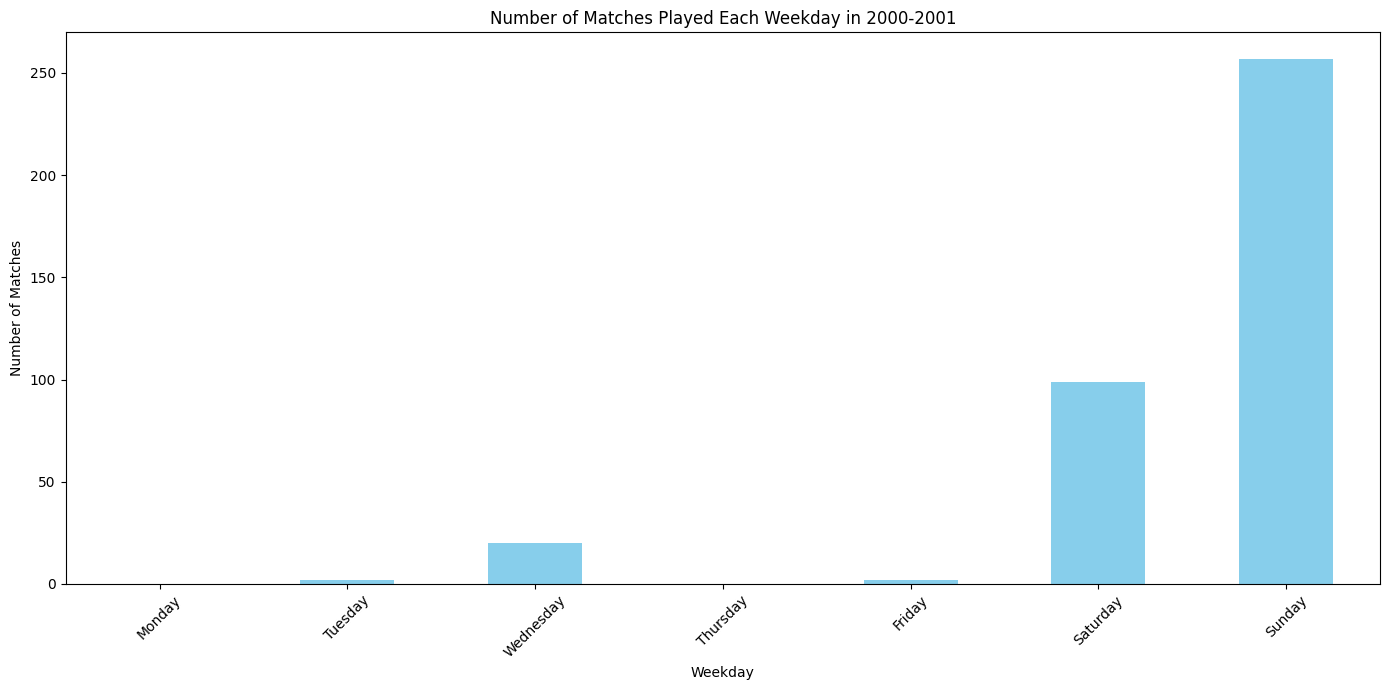

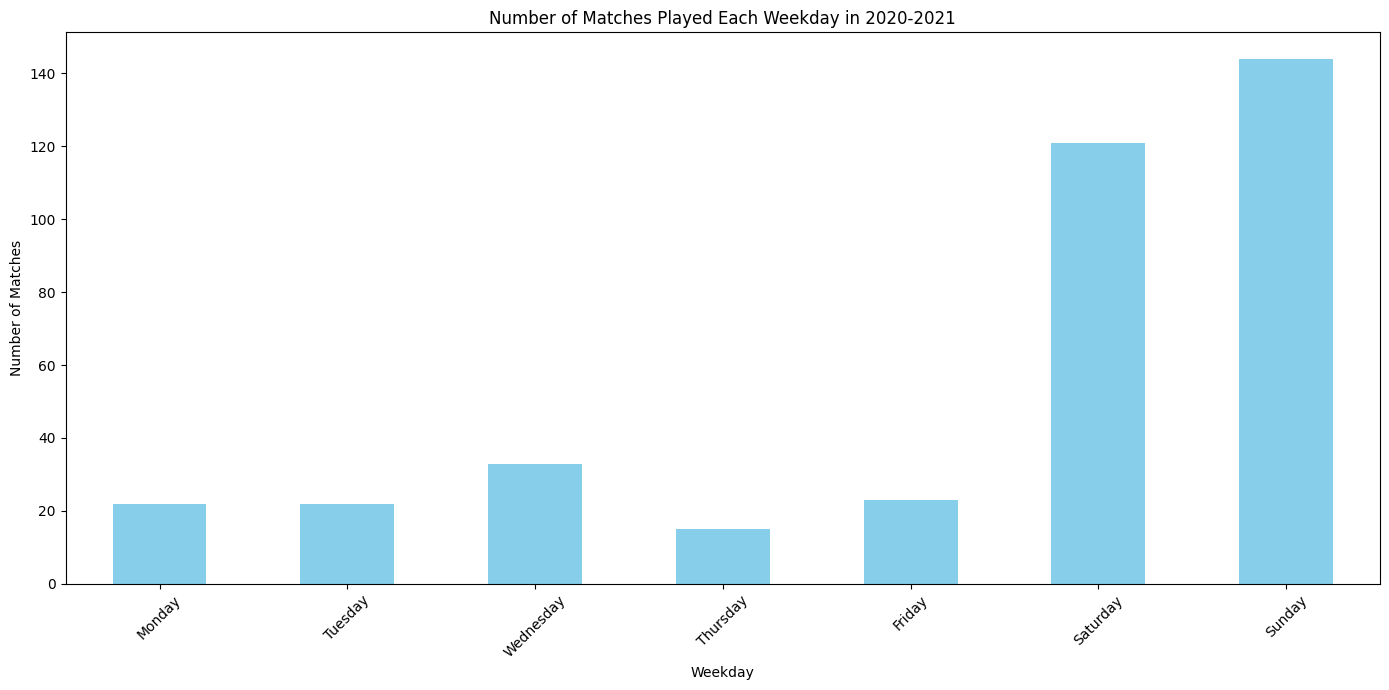

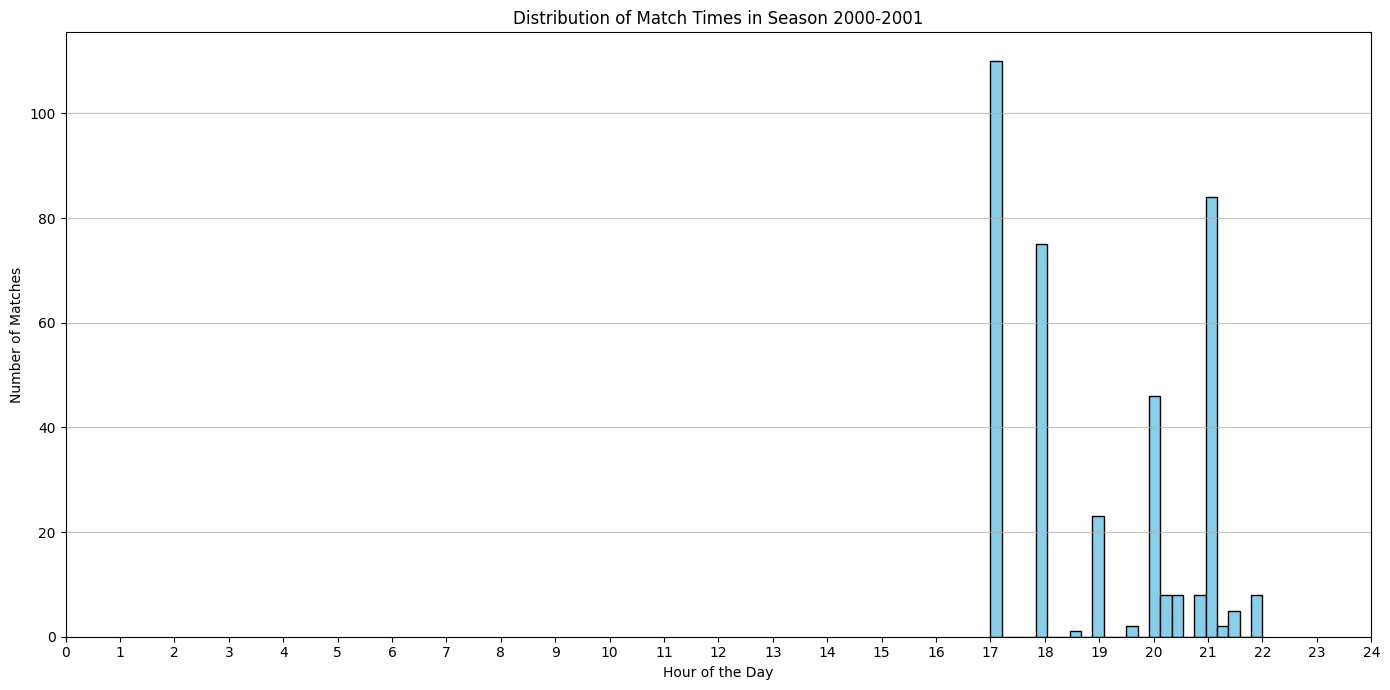

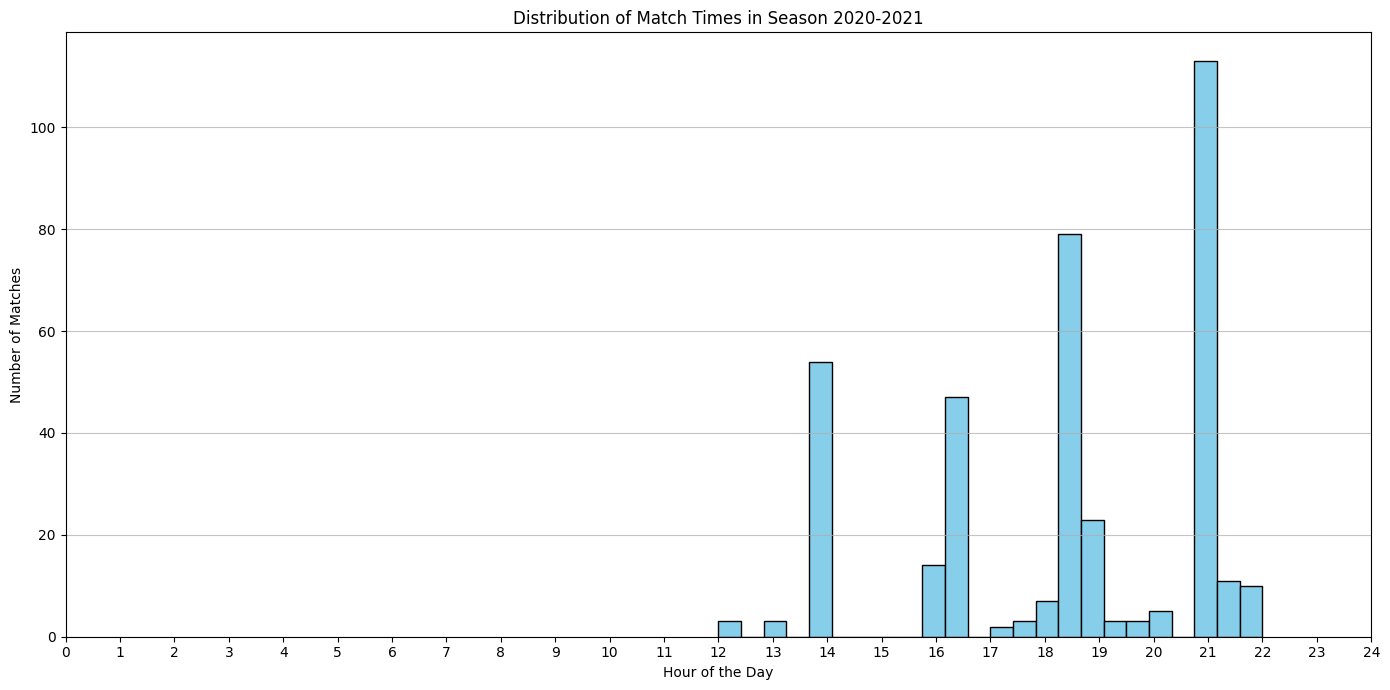

In [28]:
# Standardize the date and time formats and extract weekdays and times
def standardize_date_time(data):
    # Convert the date column to datetime
    data['date'] = data['date'].apply(parse_date_mdy_format)
    data['date'] = pd.to_datetime(data['date'], errors='coerce', format='%Y-%m-%d')
    
    # Extract the weekday from the date
    data['weekday'] = data['date'].dt.day_name()
     
    # Apply the conversion to the time column
    data['time_24h'] = data['time'].apply(convert_time_to_24h)
    
    # Drop rows with NaT in date due to conversion errors
    data.dropna(subset=['date'], inplace=True)
    
    return data

# Query to get all the dates and times from the Matches table
date_time_query = """
SELECT 
    season, 
    date, 
    time 
FROM 
    Matches 
WHERE 
    division = 1 AND 
    season IN ('2000-2001', '2020-2021') AND 
    date IS NOT NULL;
"""

# Execute the query and return the result
date_time_data = run_query(date_time_query, conn)

# Apply the standardization function to the data
standardized_date_time_data = standardize_date_time(date_time_data)

# Filter the data for the seasons 2000-2001 and 2020-2021
season_2000_2001_data = standardized_date_time_data[standardized_date_time_data['season'] == '2000-2001']
season_2020_2021_data = standardized_date_time_data[standardized_date_time_data['season'] == '2020-2021']

# Get the counts of matches by weekday for each season
weekday_counts_2000_2001 = season_2000_2001_data['weekday'].value_counts()
weekday_counts_2020_2021 = season_2020_2021_data['weekday'].value_counts()

# Plot the bar charts for number of matches played each weekday
plt.figure(figsize=(14, 7))
weekday_counts_2000_2001.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(kind='bar', color='skyblue')
plt.title('Number of Matches Played Each Weekday in 2000-2001')
plt.xlabel('Weekday')
plt.ylabel('Number of Matches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
weekday_counts_2020_2021.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(kind='bar', color='skyblue')
plt.title('Number of Matches Played Each Weekday in 2020-2021')
plt.xlabel('Weekday')
plt.ylabel('Number of Matches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Histogram function
def plot_histogram_of_time(data, season):
    # Drop rows where time is None
    valid_times = data.dropna(subset=['time_24h'])['time_24h'].apply(lambda x: x.hour + x.minute/60)
    plt.figure(figsize=(14, 7))
    plt.hist(valid_times, bins=24, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of Match Times in Season {season}')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Matches')
    plt.xlim(0, 24)
    plt.xticks(range(0, 25, 1))
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()

# Plot the histograms for match times
plot_histogram_of_time(season_2000_2001_data, '2000-2001')
plot_histogram_of_time(season_2020_2021_data, '2020-2021')

## 4.
Build a cross results table for season 2020-2021 (1st division). Figure 1 in the instructions is an example taken from Wikipedia. Try to make it the most similar to this one, painting the background of each cell according to result (green in case local team wins and red in case visitor team wins). Also, could you model the intensity of this background color with the goal difference from the match?

Write a function that, given the season and division, plots the cross results table. Function prototype should be like plot_cross_results_table(season, division) and return the plot object.

<Axes: title={'center': 'Cross Results Table for 2020-2021 (Division 1)'}, xlabel='Away Teams', ylabel='Home Teams'>

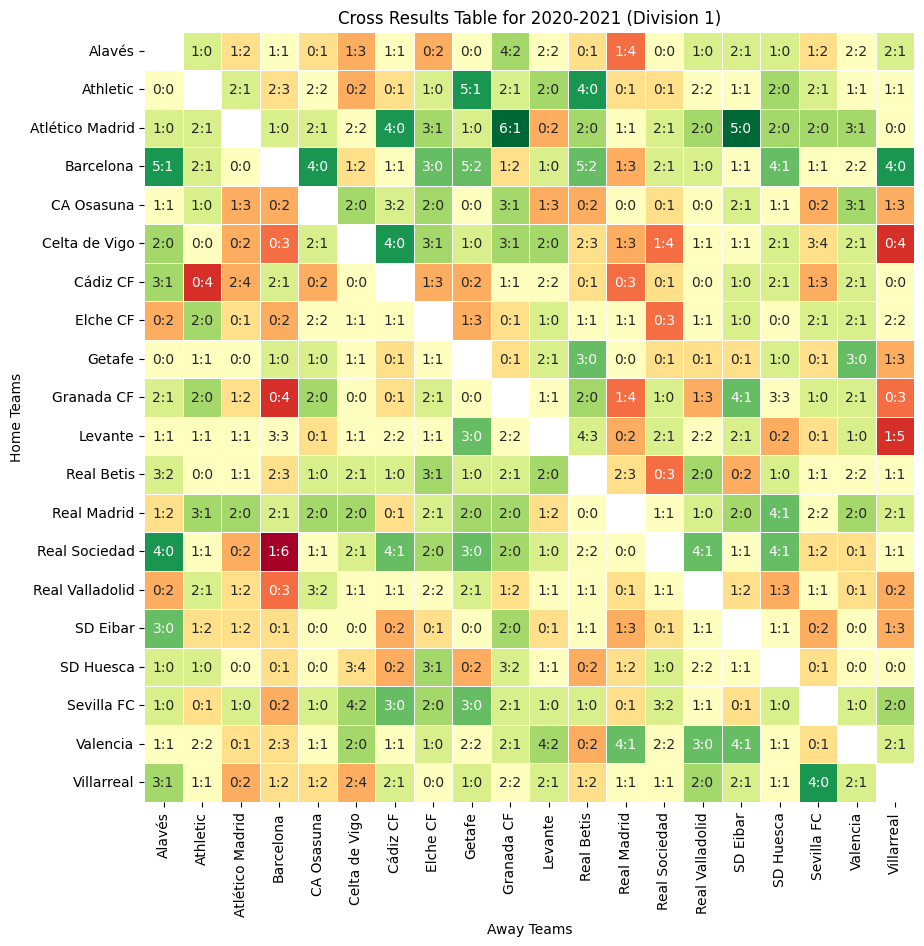

In [29]:
# Function to plot the cross results table with the specified details
def plot_cross_results_table(season, division):
    # Extract matches for the given season and division using the previously defined `run_query` function
    matches_query = f"""
    SELECT home_team, away_team, score 
    FROM Matches 
    WHERE season='{season}' AND division={division} AND score IS NOT NULL;
    """
    matches = run_query(matches_query, conn)
    
    # Create a set of unique teams for the given season and division
    teams = sorted(set(matches['home_team'].unique()) | set(matches['away_team'].unique()))
    
    # Create an empty dataframe to store results with teams as both columns and index
    results_df = pd.DataFrame('-', index=teams, columns=teams)
    color_matrix = pd.DataFrame(0, index=teams, columns=teams, dtype=float)
    
    # Populate the results dataframe and color matrix
    for index, match in matches.iterrows():
        home_team, away_team, score = match
        if ':' in score:  # Ensure score is in the correct format
            home_goals, away_goals = map(int, score.split(':'))
            goal_diff = home_goals - away_goals
            results_df.loc[home_team, away_team] = score
            color_matrix.loc[home_team, away_team] = goal_diff  # Positive for home win, negative for away win
    
    # Normalize the goal difference for color intensity
    max_goal_diff = max(color_matrix.max().max(), -color_matrix.min().min())
    norm = plt.Normalize(-max_goal_diff, max_goal_diff)
    colors = plt.cm.RdYlGn(norm(color_matrix.values))

    # Create mask for cells that should not be colored (diagonal and non-played games)
    mask = (results_df == '-')

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(color_matrix, annot=results_df, fmt="", cmap="RdYlGn", linewidths=.5, 
                cbar=False, xticklabels=teams, yticklabels=teams, vmin=-max_goal_diff, vmax=max_goal_diff, ax=ax,
                mask=mask, square=True)
    
    plt.title(f"Cross Results Table for {season} (Division {division})")
    plt.xlabel('Away Teams')
    plt.ylabel('Home Teams')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    return ax

plot_cross_results_table('2020-2021', 1)

## 5.
As you surely know, there has always been a historical rivalry between Barcelona and Real Madrid. But which of them has won the most games in direct confrontations? Which of them has scored the most goals in these games? Show both things in two pie charts, side by side. Remember to consider ties in the first one.

Write a function that, given two team names, plots the two graphs described above. Function prototype should be like plot_direct_confrontations_- stats(team1, team2) and return the plot object. Use it with some other classical rivals like Betis and Sevilla.

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

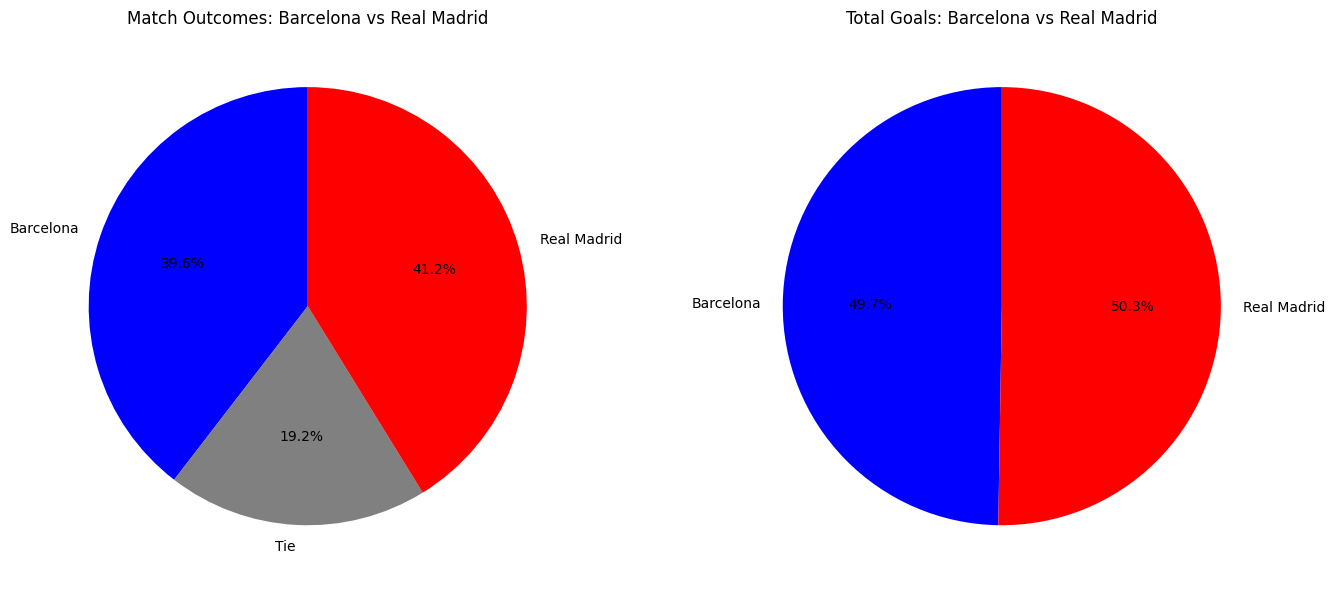

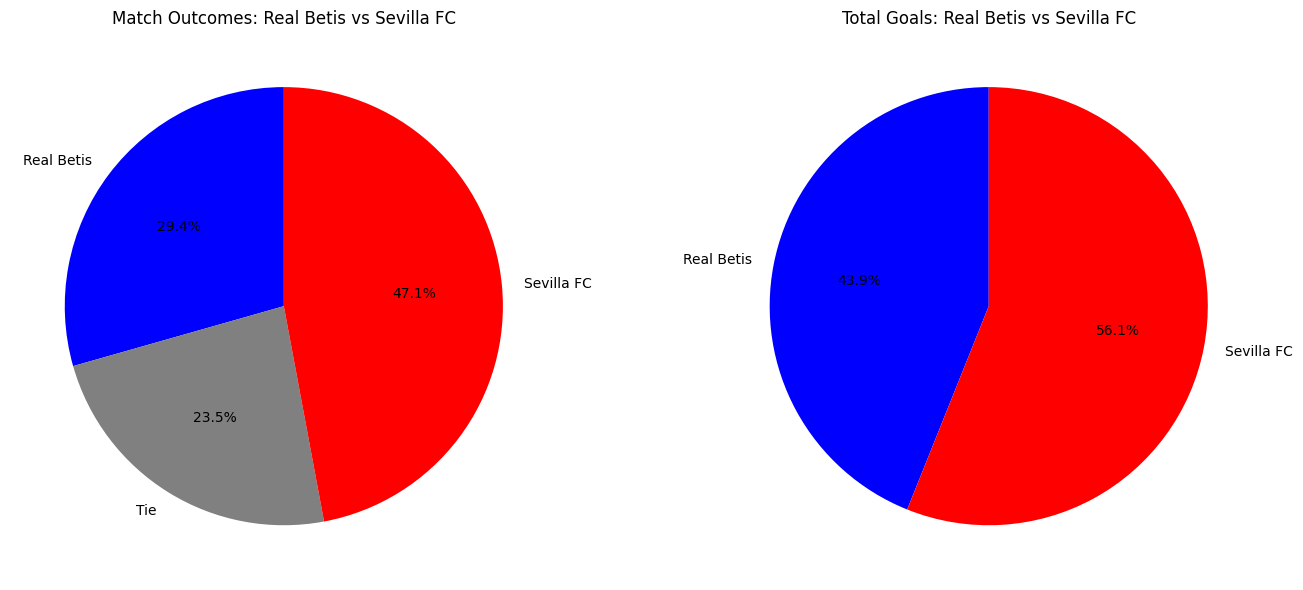

In [30]:
def get_direct_confrontations_stats(team1, team2):
    # Extract matches where either team1 is the home team and team2 is the away team, or vice versa
    direct_matches_query = f"""
    SELECT home_team, away_team, score 
    FROM Matches 
    WHERE (home_team='{team1}' AND away_team='{team2}' AND score IS NOT NULL) 
       OR (home_team='{team2}' AND away_team='{team1}' AND score IS NOT NULL);
    """
    direct_matches = run_query(direct_matches_query, conn)
    
    # Initialize counters for wins and goals
    team1_wins = 0
    team2_wins = 0
    ties = 0
    team1_goals = 0
    team2_goals = 0
    
    for index, match in direct_matches.iterrows():
        home_team, away_team, score = match
        home_goals, away_goals = map(int, score.split(':'))

        # Update win counters
        if home_goals > away_goals:
            team1_wins += (home_team == team1)
            team2_wins += (home_team == team2)
        elif home_goals < away_goals:
            team1_wins += (away_team == team1)
            team2_wins += (away_team == team2)
        else:
            ties += 1

        # Update goal counters
        team1_goals += home_goals if home_team == team1 else away_goals
        team2_goals += away_goals if away_team == team2 else home_goals
    
    return team1_wins, team2_wins, ties, team1_goals, team2_goals

def plot_direct_confrontations_stats(team1, team2):
    # Get direct confrontation stats for the given teams
    team1_wins, team2_wins, ties, team1_goals, team2_goals = get_direct_confrontations_stats(team1, team2)
    
    # Data for match outcomes pie chart
    outcome_labels = [team1, 'Tie', team2]
    outcome_sizes = [team1_wins, ties, team2_wins]
    outcome_colors = ['blue', 'grey', 'red']
    
    # Data for goals pie chart
    goals_labels = [team1, team2]
    goals_sizes = [team1_goals, team2_goals]
    goals_colors = ['blue', 'red']
    
    # Plotting the pie charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    ax1.pie(outcome_sizes, labels=outcome_labels, colors=outcome_colors, autopct='%1.1f%%', startangle=90)
    ax1.set_title(f"Match Outcomes: {team1} vs {team2}")
    
    ax2.pie(goals_sizes, labels=goals_labels, colors=goals_colors, autopct='%1.1f%%', startangle=90)
    ax2.set_title(f"Total Goals: {team1} vs {team2}")
    
    plt.tight_layout()
    return plt

plot_direct_confrontations_stats("Barcelona", "Real Madrid")
plot_direct_confrontations_stats("Real Betis", "Sevilla FC")


## 6.
Between 1979 and 1980, Real Sociedad managed to chain a total of 38 games without losing. That was, by far, the longest undefeated streak in their history. Which teams have had the longest undefeated streaks? Show the longest undefeated streaks in a horizontal bar plot, indicating in each bar the team name and the dates it held that streak, for instance, Real Sociedad 22/04/1979 - 04/05/1980.

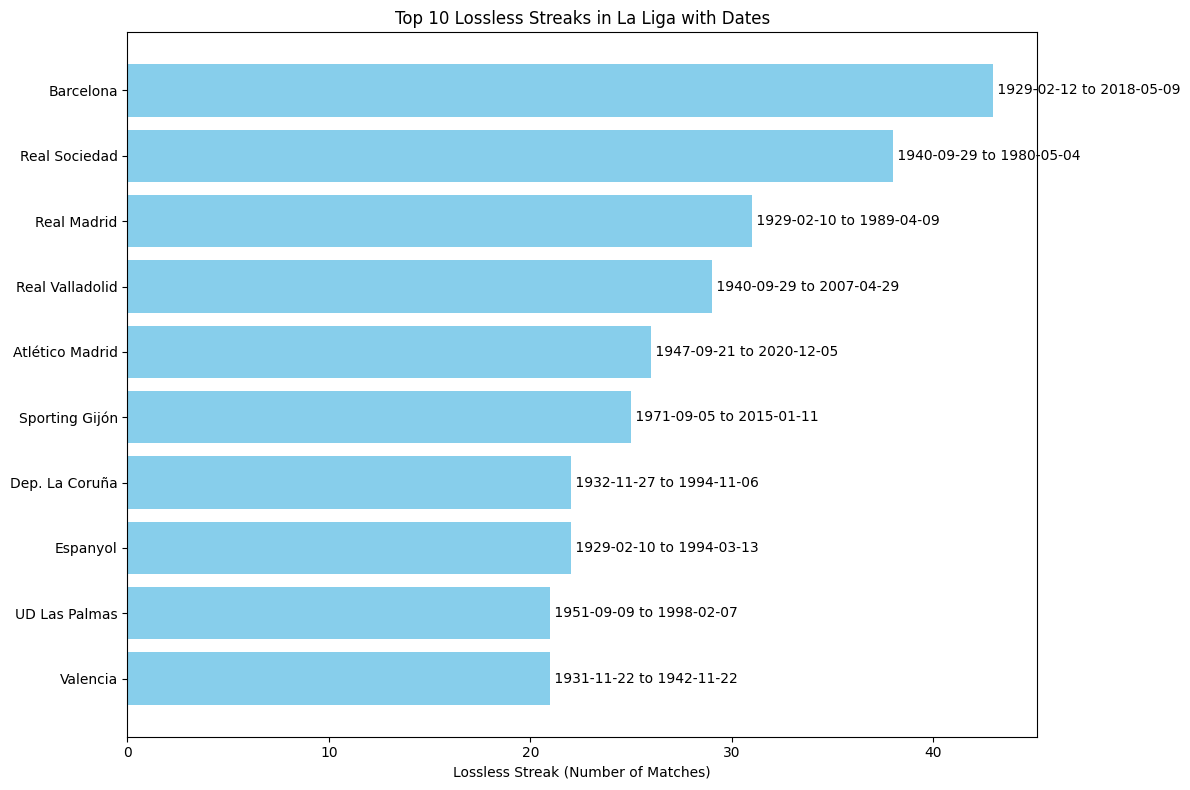

In [37]:
# Query all matches excluding those with null scores
df_matches = pd.read_sql_query('SELECT season, division, matchday, date, home_team, away_team, score FROM Matches WHERE score IS NOT NULL', conn)

df_matches.dropna(subset=['date'], inplace=True)
# Standardize the date format
df_matches['date'] = df_matches['date'].apply(parse_date_mdy_format)

# Determine the result for each match
df_matches[['home_goals', 'away_goals']] = df_matches['score'].str.split(':', expand=True).astype(int)
df_matches['home_outcome'] = df_matches.apply(lambda x: 'Win' if x['home_goals'] > x['away_goals'] else 'Loss' if x['home_goals'] < x['away_goals'] else 'Draw', axis=1)
df_matches['away_outcome'] = df_matches.apply(lambda x: 'Win' if x['away_goals'] > x['home_goals'] else 'Loss' if x['away_goals'] < x['home_goals'] else 'Draw', axis=1)

# Split the matches into two rows per match for home and away teams
df_home = df_matches[['date', 'home_team', 'home_outcome']].rename(columns={'home_team': 'team', 'home_outcome': 'outcome'})
df_away = df_matches[['date', 'away_team', 'away_outcome']].rename(columns={'away_team': 'team', 'away_outcome': 'outcome'})
df_outcomes = pd.concat([df_home, df_away], ignore_index=True)
df_outcomes_sorted = df_outcomes.sort_values(by=['team', 'date']).reset_index(drop=True)

# Function to calculate streaks with dates
def calculate_streaks_with_dates(df):
    max_streaks_with_dates = {}
    current_streak = 0
    current_start_date = None
    current_team = None
    for index, row in df.iterrows():
        team, outcome, date = row['team'], row['outcome'], row['date']
        if team != current_team:
            if current_team is not None and current_streak > max_streaks_with_dates.get(current_team, (0, None, None))[0]:
                max_streaks_with_dates[current_team] = (current_streak, current_start_date, prev_date)
            current_streak = 0
            current_start_date = date
            current_team = team
        if outcome != 'Loss':
            current_streak += 1
        else:
            if current_streak > max_streaks_with_dates.get(current_team, (0, None, None))[0]:
                max_streaks_with_dates[current_team] = (current_streak, current_start_date, prev_date)
            current_streak = 0
        prev_date = date
    if current_streak > max_streaks_with_dates.get(current_team, (0, None, None))[0]:
        max_streaks_with_dates[current_team] = (current_streak, current_start_date, prev_date)
    return max_streaks_with_dates

# Calculate streaks and sort them
team_streaks_with_dates = calculate_streaks_with_dates(df_outcomes_sorted)
sorted_streaks_with_dates = sorted(team_streaks_with_dates.items(), key=lambda item: item[1][0], reverse=True)

# Plot the top streaks with dates
df_top_streaks = pd.DataFrame(sorted_streaks_with_dates[:10], columns=['Team', 'StreakData'])
df_top_streaks[['Streak', 'Start', 'End']] = pd.DataFrame(df_top_streaks['StreakData'].tolist(), index=df_top_streaks.index)
df_top_streaks.drop(columns=['StreakData'], inplace=True)
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(df_top_streaks['Team'], df_top_streaks['Streak'], color='skyblue')
for bar, start_date, end_date in zip(bars, df_top_streaks['Start'], df_top_streaks['End']):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {start_date} to {end_date}', va='center', ha='left')
ax.set_xlabel('Lossless Streak (Number of Matches)')
ax.set_title('Top 10 Lossless Streaks in La Liga with Dates')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 7.
Create a table with the final standings of each season (and division), that is, a table that contains all the teams ordered (in descending order) by the number of points they got during that season, and some other aggregate statistics. The table must contain the following columns: season, division, ranking, team, GF (total goals scored), GA (total goals conceded), GD (goals difference), W (total wins), L (total loses), T (total ties), Pts (points). Remember that, in football, you earn 3 points per victory, and 1 point per tie (none for loses). In case two teams have same number of points, order by GD (descending), and then by GF (also descending). Order the table so that standings of one season come before standings of previous one, and standings of 1st division come before standings of 2nd division.

Save the final tabel in Excel with the name SeasonStandings.xlsx in the reports/ folder.

In [32]:
def calculate_standings(season, division, matches_df):
    # Filter matches for the given season and division
    season_matches = matches_df[(matches_df['season'] == season) & (matches_df['division'] == division)]
    
    # Split the score into home and away goals
    split_scores = season_matches['score'].str.split(':', expand=True).astype(int)
    home_goals, away_goals = split_scores[0], split_scores[1]
    
    # Calculate wins, draws, and losses for both home and away
    home_win = home_goals > away_goals
    away_win = away_goals > home_goals
    tie = home_goals == away_goals
    home_loss = home_goals < away_goals
    away_loss = away_goals < home_goals
    
    # Aggregate home data
    home_data = season_matches[['home_team']].assign(
        GF=home_goals, GA=away_goals, PTS=3*home_win + tie,
        W=home_win, L=home_loss, T=tie
    ).rename(columns={'home_team': 'Team'})
    
    # Aggregate away data
    away_data = season_matches[['away_team']].assign(
        GF=away_goals, GA=home_goals, PTS=3*away_win + tie,
        W=away_win, L=away_loss, T=tie
    ).rename(columns={'away_team': 'Team'})
    
    # Combine home and away data
    all_data = pd.concat([home_data, away_data], ignore_index=True)
    
    # Aggregate the results by team
    standings = all_data.groupby('Team', as_index=False).sum()
    standings['GD'] = standings['GF'] - standings['GA']
    standings['Season'] = season
    standings['Division'] = division
    
    # Sort the standings and assign rank
    standings.sort_values(by=['PTS', 'GD', 'GF'], ascending=[False, False, False], inplace=True)
    standings['Rank'] = range(1, len(standings) + 1)
    
    # Select and order the columns
    standings_columns = ['Season', 'Division', 'Rank', 'Team', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'PTS']
    final_standings = standings[standings_columns]
    
    return final_standings

matches = run_query('SELECT * FROM Matches', conn)
matches.dropna(subset=['score'], inplace=True)
matches['date'] = matches['date'].apply(parse_date_mdy_format)

standings_2020_2021_div1 = calculate_standings('2020-2021', 1, matches)
standings_2020_2021_div1


,Season,Division,Rank,Team,GF,GA,GD,W,L,T,PTS
2,2020-2021,1,1,Atlético Madrid,67,25,42,26,4,8,86
12,2020-2021,1,2,Real Madrid,67,28,39,25,4,9,84
3,2020-2021,1,3,Barcelona,85,38,47,24,7,7,79
17,2020-2021,1,4,Sevilla FC,53,33,20,24,9,5,77
13,2020-2021,1,5,Real Sociedad,59,38,21,17,10,11,62
11,2020-2021,1,6,Real Betis,50,50,0,17,11,10,61
19,2020-2021,1,7,Villarreal,60,44,16,15,10,13,58
5,2020-2021,1,8,Celta de Vigo,55,57,-2,14,13,11,53
1,2020-2021,1,9,Athletic,46,42,4,11,14,13,46
9,2020-2021,1,10,Granada CF,47,65,-18,13,18,7,46


In [33]:
def calculate_all_standings(matches_df):
    # This function assumes that the 'calculate_standings' function is already defined as optimized before
    
    # Group by season and division and calculate standings for each group
    all_standings = (
        matches_df.groupby(['season', 'division'])
        .apply(lambda x: calculate_standings(x.name[0], x.name[1], x))
        .reset_index(drop=True)
    )
    
    # Sort the standings by Season and Division (newest to oldest)
    all_standings_sorted = all_standings.sort_values(by=['Season', 'Division'], ascending=[False, True]).reset_index(drop=True)
    
    return all_standings_sorted

# Use the function to calculate all standings
all_standings_sorted = calculate_all_standings(matches)
all_standings_sorted


,Season,Division,Rank,Team,GF,GA,GD,W,L,T,PTS
0,2021-2022,1,1,Real Madrid,8,4,4,2,0,1,7
1,2021-2022,1,2,Sevilla FC,5,1,4,2,0,1,7
2,2021-2022,1,3,Valencia,5,1,4,2,0,1,7
3,2021-2022,1,4,Barcelona,7,4,3,2,0,1,7
4,2021-2022,1,5,Atlético Madrid,5,3,2,2,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...
2781,1928-1929,1,6,Athletic Madrid,43,41,2,8,8,2,26
2782,1928-1929,1,7,Espanyol,32,38,-6,7,7,4,25
2783,1928-1929,1,8,Catalunya,45,49,-4,6,8,4,22
2784,1928-1929,1,9,Real Unión,40,42,-2,5,11,2,17


In [38]:
all_standings_sorted.to_excel('../reports/SeasonStandings.xlsx', index=False)


# 8.
Villarreal is a team that has grown a lot in recent decades. Specially ever since some billionaire guy bought it (Fernando Roig, from Mercadona).

Make a line plot showing the rank of Villarreal at the end of each season, from the oldest ones (left) to the earliest ones (right). Consider rankings in 2nd division to be a continuation of the 1st one, that is, if there’s N teams in 1st division and Villarreal got r position in 2nd division, then it should be placed in N +r. Draw in the same plot a line showing the cut between 1st and 2nd division.

Write a function that, given n team names, plots the graph described above of each one of them superposed. Function prototype should be like plot_ranking_evolution(team1, team2, ..., teamN) and return the plot object (note that function should not take one array-type argument, but n arguments). Use it to compare the evolution of all the teams that currently play in 1st division.

<Axes: title={'center': 'Ranking Evolution of Teams'}, xlabel='Season', ylabel='Rank'>

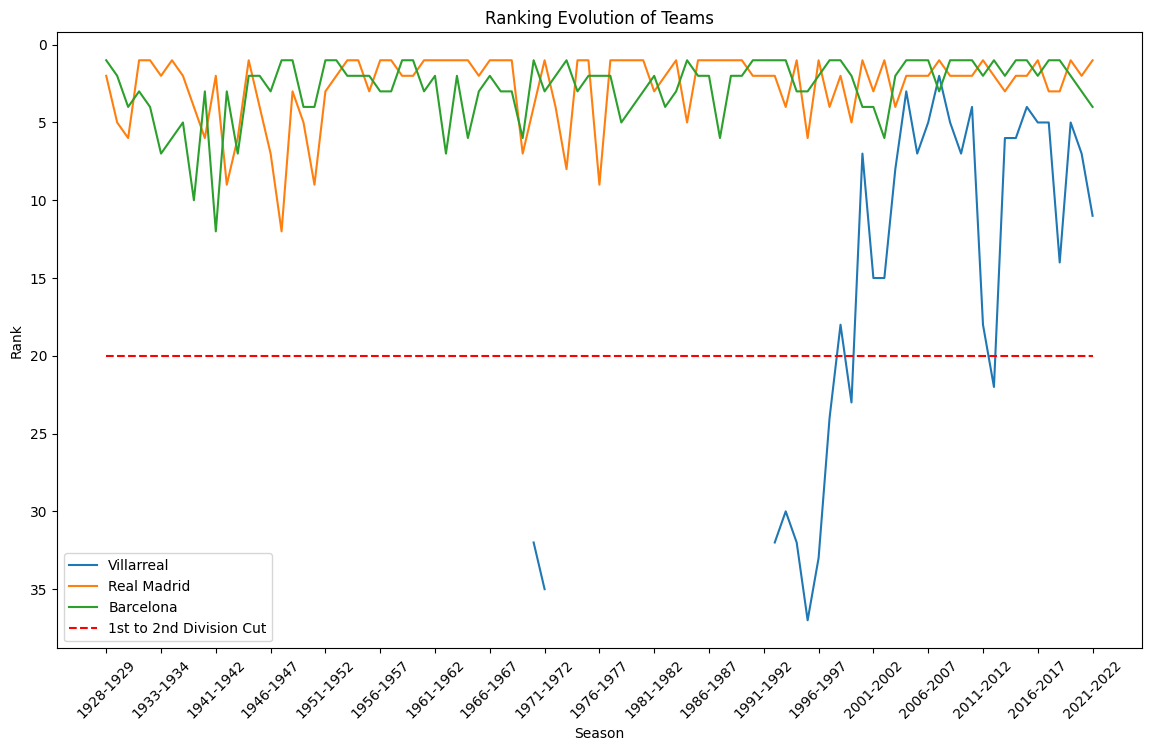

In [ ]:
def plot_ranking_evolution(*teams):
    # Get unique seasons
    seasons = sorted(all_standings_sorted['Season'].unique())
    
    # Initialize a plot
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot each team's ranking evolution
    for team in teams:
        ranks = []
        for season in seasons:
            # Get the standings for the team in the season
            team_standings = all_standings_sorted[(all_standings_sorted['Season'] == season) & (all_standings_sorted['Team'] == team)]
            if not team_standings.empty:
                # Assume continuation from 1st to 2nd division as per the requirement
                rank = team_standings['Rank'].iloc[0]
                division = team_standings['Division'].iloc[0]
                if division == 2:
                    rank += all_standings_sorted[(all_standings_sorted['Season'] == season) & (all_standings_sorted['Division'] == 1)].shape[0]
                ranks.append(rank)
            else:
                # If the team didn't play in the first or second division that season, append None
                ranks.append(None)
        
        # Plot the team's rank over the seasons
        ax.plot(seasons, ranks, label=team)

    # Drawing the division cut line (assuming there are always 20 teams in the 1st division)
    division_cut = [20] * len(seasons)
    ax.plot(seasons, division_cut, label='1st to 2nd Division Cut', color='red', linestyle='--')

    # Set plot labels and title
    ax.set_xlabel('Season')
    ax.set_ylabel('Rank')
    ax.set_title('Ranking Evolution of Teams')
    ax.set_xticks(range(0, len(seasons), 5))  # Show every 5th season for clarity
    ax.set_xticklabels(seasons[::5], rotation=45)  # Rotate labels for better readability
    ax.invert_yaxis()  # Invert y-axis to have the best rank on top
    ax.legend()
    
    return ax

plot_ranking_evolution('Villarreal', 'Real Madrid', 'Barcelona')
# plt.show()

# 9.
In football jargon, those teams that are permanently descending and ascending between 1st and 2nd division are called elevator teams. What are the most elevator teams in LaLiga? Plot the history of the top 5 of them using the function from exercise 8.

<Axes: title={'center': 'Ranking Evolution of Teams'}, xlabel='Season', ylabel='Rank'>

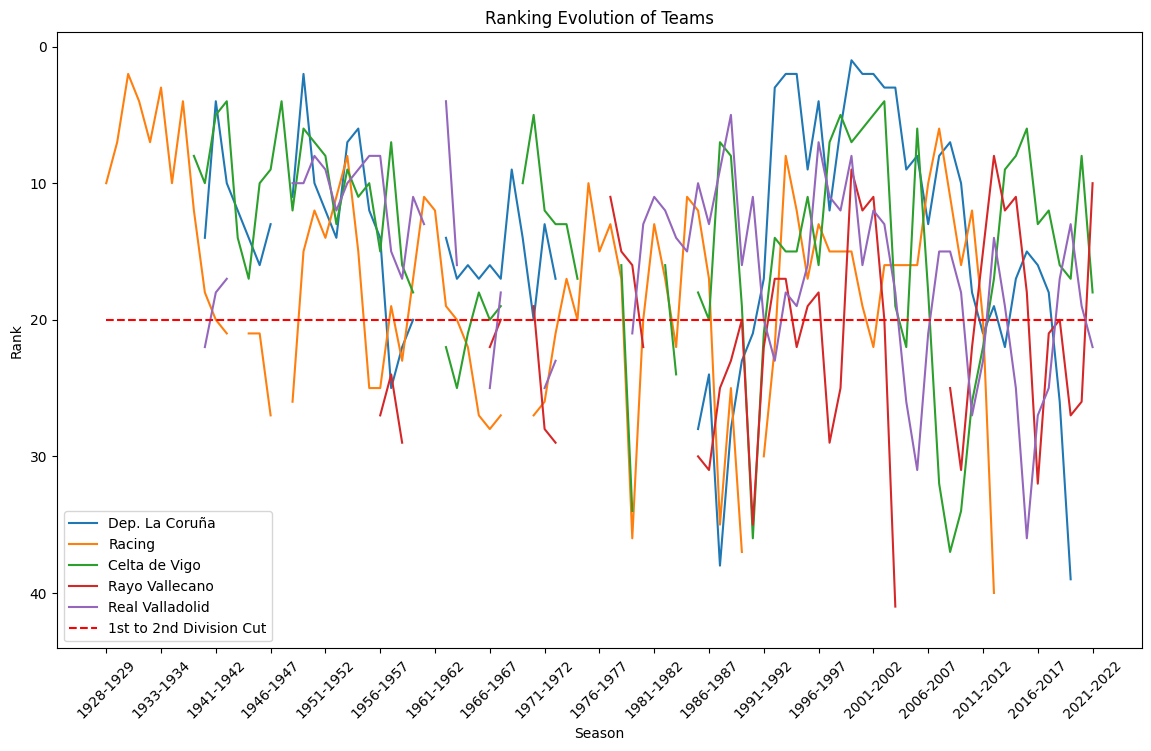

In [ ]:
def calculate_division_changes(standings_table):
    # Sort the standings by team and season
    standings_sorted = standings_table.sort_values(by=['Team', 'Season'])
    
    # Shift the 'Division' column to compare with the next season's division
    standings_sorted['PrevDivision'] = standings_sorted.groupby('Team')['Division'].shift()
    
    # Calculate changes by checking where the division is not equal to the previous season's division
    standings_sorted['DivisionChange'] = (standings_sorted['Division'] != standings_sorted['PrevDivision']).astype(int)
    
    # Group by team and sum the division changes
    division_change_summary = standings_sorted.groupby('Team')['DivisionChange'].sum().reset_index()
    
    # Sort teams by the number of division changes, descending
    division_change_summary = division_change_summary.sort_values(by='DivisionChange', ascending=False)
    
    # Get the top 5 elevator teams
    top_elevator_teams = division_change_summary.head(5)
    
    return top_elevator_teams

top_elevator_teams = calculate_division_changes(all_standings_sorted)

plot_ranking_evolution(*top_elevator_teams['Team'].tolist())


In [ ]:
top_elevator_teams

,Team,DivisionChange
65,Dep. La Coruña,21
103,Racing,18
58,Celta de Vigo,18
105,Rayo Vallecano,16
117,Real Valladolid,15


# 10.
Create a table that is the same as the one in exercise 7, but not only with the season final standings, but the standings at the end of each matchday. Columns are the same, including matchday that tells about which matchday from the season these standings are from. Would you be able to add a new column last_5 with the result of last 5 matches? This column should contain a list like ["W", "L", "W", "T", "T"]. In this list, the first item is the immediate previous match, the second one is the match before this one, and so on. If there are no 5 previous matches (because matchday < 6, for instance) then just make the list shorter.

Save the final table in Excel with the name MatchdayStandings.xlsx in the
reports/ folder.

In [ ]:
import pandas as pd
from datetime import datetime

# Helper function to determine match outcomes
def determine_outcome(home_goals, away_goals):
    if home_goals > away_goals:
        return 'W', 'L'
    elif home_goals < away_goals:
        return 'L', 'W'
    else:
        return 'T', 'T'

# Main function to calculate matchday standings with last 5 results
def calculate_matchday_standings(matches_df):
    # Ensure the dataframe is sorted by season, division, and matchday
    matches_df = matches_df.sort_values(by=['season', 'division', 'matchday'])

    # Initialize a list to hold all matchday standings
    all_standings = []
    
    # Loop through each unique season and division
    for (season, division), group in matches_df.groupby(['season', 'division']):
        # Initialize a dictionary to store current standings and last 5 match results
        standings_dict = {}
        last_5_dict = {}
        
        # Loop through each matchday
        for matchday in group['matchday'].unique():
            matchday_group = group[group['matchday'] == matchday]
            
            # Loop through each match in the matchday
            for index, row in matchday_group.iterrows():
                home_team, away_team = row['home_team'], row['away_team']
                home_goals, away_goals = map(int, row['score'].split(':'))
                home_outcome, away_outcome = determine_outcome(home_goals, away_goals)
                
                # Update last 5 matches
                last_5_dict.setdefault(home_team, []).insert(0, home_outcome)
                last_5_dict.setdefault(away_team, []).insert(0, away_outcome)
                
                # Update standings
                if home_team not in standings_dict:
                    standings_dict[home_team] = {'GF': 0, 'GA': 0, 'PTS': 0, 'W': 0, 'L': 0, 'T': 0}
                if away_team not in standings_dict:
                    standings_dict[away_team] = {'GF': 0, 'GA': 0, 'PTS': 0, 'W': 0, 'L': 0, 'T': 0}
                
                # Update goals and points
                standings_dict[home_team]['GF'] += home_goals
                standings_dict[home_team]['GA'] += away_goals
                standings_dict[away_team]['GF'] += away_goals
                standings_dict[away_team]['GA'] += home_goals
                
                # Update wins, losses, ties
                if home_goals > away_goals:
                    standings_dict[home_team]['PTS'] += 3
                    standings_dict[home_team]['W'] += 1
                    standings_dict[away_team]['L'] += 1
                elif home_goals < away_goals:
                    standings_dict[away_team]['PTS'] += 3
                    standings_dict[away_team]['W'] += 1
                    standings_dict[home_team]['L'] += 1
                else:
                    standings_dict[home_team]['PTS'] += 1
                    standings_dict[away_team]['PTS'] += 1
                    standings_dict[home_team]['T'] += 1
                    standings_dict[away_team]['T'] += 1
                
                # Ensure last_5 lists do not exceed 5 matches
                last_5_dict[home_team] = last_5_dict[home_team][:5]
                last_5_dict[away_team] = last_5_dict[away_team][:5]
            
            # Create a DataFrame from the current standings
            matchday_standings = pd.DataFrame.from_dict(standings_dict, orient='index').reset_index()
            matchday_standings.rename(columns={'index': 'Team'}, inplace=True)
            matchday_standings['GD'] = matchday_standings['GF'] - matchday_standings['GA']
            matchday_standings['Season'] = season
            matchday_standings['Division'] = division
            matchday_standings['Matchday'] = matchday
            matchday_standings['last_5'] = matchday_standings['Team'].apply(lambda x: last_5_dict[x])
            
            # Sort the standings for the current matchday
            matchday_standings.sort_values(by=['PTS', 'GD', 'GF'], ascending=[False, False, False], inplace=True)
            matchday_standings['Rank'] = range(1, len(matchday_standings) + 1)
            
            # Append to the list of all standings
            all_standings.append(matchday_standings)
    
    # Concatenate all matchday standings into one DataFrame
    return pd.concat(all_standings, ignore_index=True)

# Load data from the database
matches = run_query('SELECT * FROM Matches', conn)
matches.dropna(subset=['score'], inplace=True)
matches['date'] = matches['date'].apply(parse_date_mdy_format)

# Calculate the standings for each matchday
matchday_standings = calculate_matchday_standings(matches)

In [ ]:
matchday_standings

,Team,GF,GA,PTS,W,L,T,GD,Season,Division,Matchday,last_5,Rank
0,Real Madrid,5,0,3,1,0,0,5,1928-1929,1,1,"[W, W]",1
1,Barcelona,2,0,3,1,0,0,2,1928-1929,1,1,"[L, W]",2
2,Athletic Madrid,3,2,3,1,0,0,1,1928-1929,1,1,"[L, W]",3
3,Espanyol,3,2,3,1,0,0,1,1928-1929,1,1,"[L, W]",4
4,Donostia,1,1,1,0,0,1,0,1928-1929,1,1,"[W, T]",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96061,CD Leganés,1,3,1,0,2,1,-2,2021-2022,2,3,"[L, T, L]",18
96062,Real Zaragoza,0,2,1,0,1,1,-2,2021-2022,2,3,"[L, T]",19
96063,Burgos CF,0,2,1,0,2,1,-2,2021-2022,2,3,"[L, T, L]",20
96064,FC Cartagena,1,5,0,0,2,0,-4,2021-2022,2,3,"[L, L]",21


In [ ]:
def calculate_single_season_division_standings(season, division, matches_df):
    # Filter matches for the given season and division
    season_matches = matches_df[(matches_df['season'] == season) & (matches_df['division'] == division)].sort_values('matchday')
    matchdays = season_matches['matchday'].unique()

    # Initialize the standings dict with teams
    teams = pd.unique(season_matches[['home_team', 'away_team']].values.ravel('K'))
    standings_tracker = {team: {'GF': 0, 'GA': 0, 'GD': 0, 'W': 0, 'L': 0, 'T': 0, 'PTS': 0, 'last_5': []} for team in teams}

    # Function to determine match outcome
    def determine_outcome(home_goals, away_goals):
        if home_goals > away_goals:
            return 'W', 'L'
        elif home_goals < away_goals:
            return 'L', 'W'
        return 'T', 'T'

    # List to collect matchday standings
    all_standings = []

    # Process each matchday
    for matchday in matchdays:
        matchday_matches = season_matches[season_matches['matchday'] == matchday]
        for index, match in matchday_matches.iterrows():
            home_team, away_team = match['home_team'], match['away_team']
            home_goals, away_goals = map(int, match['score'].split(':'))
            home_outcome, away_outcome = determine_outcome(home_goals, away_goals)

            # Update goals for and against
            standings_tracker[home_team]['GF'] += home_goals
            standings_tracker[away_team]['GF'] += away_goals
            standings_tracker[home_team]['GA'] += away_goals
            standings_tracker[away_team]['GA'] += home_goals

            # Update last 5 matches
            if matchday > 1: # Only update if it's not the first matchday
                standings_tracker[home_team]['last_5'].insert(0, home_outcome)
                standings_tracker[away_team]['last_5'].insert(0, away_outcome)

            # Ensure last_5 lists do not exceed 5 matches
            standings_tracker[home_team]['last_5'] = standings_tracker[home_team]['last_5'][:5]
            standings_tracker[away_team]['last_5'] = standings_tracker[away_team]['last_5'][:5]

            # Update wins, losses, ties, and points
            if home_goals > away_goals:  # Home win
                standings_tracker[home_team]['W'] += 1
                standings_tracker[home_team]['PTS'] += 3
                standings_tracker[away_team]['L'] += 1
            elif home_goals < away_goals:  # Away win
                standings_tracker[away_team]['W'] += 1
                standings_tracker[away_team]['PTS'] += 3
                standings_tracker[home_team]['L'] += 1
            else:  # Tie
                standings_tracker[home_team]['T'] += 1
                standings_tracker[home_team]['PTS'] += 1
                standings_tracker[away_team]['T'] += 1
                standings_tracker[away_team]['PTS'] += 1

        # Calculate goal difference
        for team in teams:
            standings_tracker[team]['GD'] = standings_tracker[team]['GF'] - standings_tracker[team]['GA']

        # Create standings DataFrame for the current matchday
        matchday_standings = (pd.DataFrame.from_dict(standings_tracker, orient='index')
                                .reset_index()
                                .rename(columns={'index': 'Team'}))
        matchday_standings['Matchday'] = matchday
        matchday_standings['Season'] = season
        matchday_standings['Division'] = division

        # Sort standings
        matchday_standings.sort_values(by=['PTS', 'GD', 'GF'], ascending=[False, False, False], inplace=True)
        matchday_standings['Rank'] = matchday_standings.reset_index().index + 1

        # Append to the list
        all_standings.append(matchday_standings)

    # Concatenate all matchday standings
    final_standings = pd.concat(all_standings, ignore_index=True)
    # Reorder columns
    final_standings = final_standings[['Season', 'Division', 'Matchday', 'Rank', 'Team', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'PTS', 'last_5']]
    
    return final_standings


calculate_single_season_division_standings('2020-2021', 1, matches).head(60)


,Season,Division,Matchday,Rank,Team,GF,GA,GD,W,L,T,PTS,last_5
0,2020-2021,1,1,1,Barcelona,3,0,3,1,0,0,3,[W]
1,2020-2021,1,1,2,Valencia,4,2,2,1,0,0,3,[L]
2,2020-2021,1,1,3,Granada CF,2,0,2,1,0,0,3,[W]
3,2020-2021,1,1,4,Atlético Madrid,2,0,2,1,0,0,3,[T]
4,2020-2021,1,1,5,Real Madrid,2,0,2,1,0,0,3,[T]
5,2020-2021,1,1,6,CA Osasuna,2,0,2,1,0,0,3,[L]
6,2020-2021,1,1,7,Real Betis,1,0,1,1,0,0,3,[W]
7,2020-2021,1,1,8,Real Valladolid,1,1,0,0,0,1,1,[L]
8,2020-2021,1,1,9,Villarreal,1,1,0,0,0,1,1,[W]
9,2020-2021,1,1,10,Real Sociedad,1,1,0,0,0,1,1,[T]


In [ ]:
def calculate_all_seasons_divisions_standings_optimized(matches_df):
    # Initialize the final DataFrame
    final_all_standings = pd.DataFrame()
    
    # Process each season and division without explicit loops
    for (season, division), group_df in matches_df.groupby(['season', 'division']):
        season_division_standings = calculate_single_season_division_standings(season, division, group_df)
        final_all_standings = pd.concat([final_all_standings, season_division_standings], ignore_index=True)
    
    return final_all_standings

all_seasons_divisions_standings_optimized = calculate_all_seasons_divisions_standings_optimized(matches)
all_seasons_divisions_standings_optimized

,Season,Division,Matchday,Rank,Team,GF,GA,GD,W,L,T,PTS,last_5
0,1928-1929,1,1,1,Real Madrid,5,0,5,1,0,0,3,[W]
1,1928-1929,1,1,2,Barcelona,2,0,2,1,0,0,3,[L]
2,1928-1929,1,1,3,Espanyol,3,2,1,1,0,0,3,[L]
3,1928-1929,1,1,4,Athletic Madrid,3,2,1,1,0,0,3,[L]
4,1928-1929,1,1,5,Donostia,1,1,0,0,0,1,1,[W]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96213,2021-2022,2,3,18,CD Leganés,1,3,-2,0,2,1,1,"[L, T]"
96214,2021-2022,2,3,19,Real Zaragoza,0,2,-2,0,1,1,1,[L]
96215,2021-2022,2,3,20,Burgos CF,0,2,-2,0,2,1,1,"[L, T]"
96216,2021-2022,2,3,21,FC Cartagena,1,5,-4,0,2,0,0,[L]


In [ ]:
def calculate_all_seasons_divisions_standings(matches_df):
    # Initialize the final DataFrame
    final_all_standings = pd.DataFrame()

    # Process each season and division without explicit loops
    for (season, division), group_df in matches_df.groupby(['season', 'division']):
        season_division_standings = calculate_single_season_division_standings(season, division, group_df)
        final_all_standings = pd.concat([final_all_standings, season_division_standings], ignore_index=True)

    return final_all_standings

standings = calculate_all_seasons_divisions_standings(matches)

In [ ]:
standings

,Season,Division,Matchday,Rank,Team,GF,GA,GD,W,L,T,PTS,last_5
0,1928-1929,1,1,1,Real Madrid,5,0,5,1,0,0,3,[W]
1,1928-1929,1,1,2,Barcelona,2,0,2,1,0,0,3,[L]
2,1928-1929,1,1,3,Espanyol,3,2,1,1,0,0,3,[L]
3,1928-1929,1,1,4,Athletic Madrid,3,2,1,1,0,0,3,[L]
4,1928-1929,1,1,5,Donostia,1,1,0,0,0,1,1,[W]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96213,2021-2022,2,3,18,CD Leganés,1,3,-2,0,2,1,1,"[L, T]"
96214,2021-2022,2,3,19,Real Zaragoza,0,2,-2,0,1,1,1,[L]
96215,2021-2022,2,3,20,Burgos CF,0,2,-2,0,2,1,1,"[L, T]"
96216,2021-2022,2,3,21,FC Cartagena,1,5,-4,0,2,0,0,[L]
